In [1]:
import sys
sys.path.insert(1, '/home/richard/nfmc_jax/')
import nfmc_jax
import arviz as az
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import scipy
from sklearn.neighbors import KernelDensity
import jax
import jax.numpy as jnp
from jax.scipy.special import logsumexp
from jax.scipy.stats import multivariate_normal as mvn
import chaospy
import corner

# 1d Gaussian likelihood and prior test for nfmc_jax

In [2]:
def log_like(x, mu=jnp.array([0]), cov=jnp.array([[1.0]])):
    return mvn.logpdf(x, mu, cov)

def log_prior(x, mu=jnp.array([0]), cov=jnp.array([[25.0]])):
    return mvn.logpdf(x, mu, cov)

key = jax.random.PRNGKey(100)
prior_samples = jax.random.multivariate_normal(key, mean=jnp.array([0.0]), 
                                               cov=jnp.array([[25.0]]), shape=(50,))
prior_samples.shape[1]

1

In [3]:
trace = nfmc_jax.infer_nfomc(log_like, log_prior, prior_samples, 
                             log_like_args=(jnp.array([0]), jnp.array([[1.0]])), 
                             log_prior_args=(jnp.array([0]), jnp.array([[25.0]])), 
                             vmap=True, parallel_backend=None, n0=100, iteration=5, 
                             N_AF=1000, expl_top_AF=40, expl_latent=5, expl_top_qw=5, local_thresh=3,
                             nfmc_draws=100, nf_iter=10, k_trunc=np.inf, ess_tol=0.9, eps_z=0.05,
                             inference_mode="sampling", cull_lowp_tol=0.01, max_cull_frac=0.0,
                             trainable_qw=False, beta_max=1)

Inference mode is sampling. Maximum beta is set to 1.


/home/richard/nfmc_jax/nfmc_jax/nfomc/nfomc.py:339: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448222085/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  self.nf_model = GIS(torch.from_numpy(np.asarray(self.samples)),
/home/richard/nfmc_jax/nfmc_jax/sinf/SINF.py:494: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at  /opt/cond

logIW3 [-0.5386758   0.72056603 -0.29298925  0.90451956 -0.56630325  3.3180456
 -0.6114149  -0.39761305  3.6077733  -0.06256223 -0.24826288  0.59862304
 -0.5844908   0.18166637 -0.34773993  3.0577297  -0.15374517  0.70477915
 -0.38059163 -0.61782503 -0.52229095 -0.62065387 -0.37730074  1.7361677
 -0.4920714   2.5823207   1.7718122   2.0712366   2.6021702   0.31629372
 -0.32776952 -0.44073367  4.7387886   0.34803438 -0.4174595   1.1555755
  0.18260098 -0.17241693  0.2786777  -0.6167232   0.2372241   0.29435253
 -0.6068399  -0.06687117 -0.61294484  1.1593702   4.830278   -0.10151958
  0.6576469   0.35984516]
self.beta before iteration 0
beta:  1.0
ESS:  11
beta:  0.5
ESS:  16
beta:  0.25
ESS:  25
self beta 0.25
logIW3 [-3.40622663e-01 -1.56365919e+00 -1.97297144e+00 -5.30185890e+00
 -7.93006420e-02 -1.08962746e+01  4.95831966e-01 -1.68824434e+00
 -1.13982830e+01 -3.02617502e+00 -1.14002478e+00 -1.13599396e+00
  9.09794569e-01 -3.84385538e+00 -2.95976210e+00 -1.00138445e+01
  2.60686874e-

qw weighted mean = -0.05075856298208237
qw weighted sd = 0.9758097529411316
sigma_prod = 0.9805806875228882
quw weighted mean = 0.10925900936126709
quw weighted sd = 1.0264863967895508


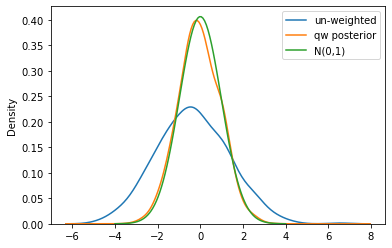

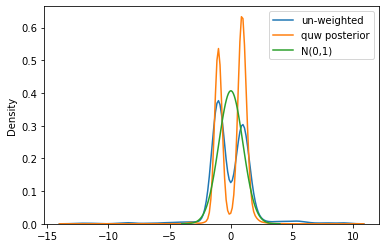

In [4]:
posterior = trace['qw_posterior'][0]
betas = trace['betas']

x = np.asarray(posterior).squeeze()
w = np.clip(trace['qw_posterior_weights'][0], a_min=0, a_max=None)

qw_mu = jnp.average(x, weights=w)
qw_sd = jnp.sqrt(jnp.average((x - qw_mu) ** 2, weights=w))

print(f'qw weighted mean = {qw_mu}')
print(f'qw weighted sd = {qw_sd}')

sigma_prod = jnp.sqrt((5.0 ** 2) / (5.0 ** 2 + 1.0 ** 2))
print(f'sigma_prod = {sigma_prod}')
def gauss(z, mu=0, cov=jnp.array([[sigma_prod ** 2]])):
    return jax.vmap(lambda x: jnp.exp(mvn.logpdf(x, mu, cov)))(z).squeeze()

z = jnp.linspace(-4, 4, 100)
plt.figure()
sns.kdeplot(x, label='un-weighted')
sns.kdeplot(x, weights=w, label='qw posterior')
plt.plot(z, gauss(z), label='N(0,1)')
plt.legend(loc='upper right')

posterior = trace['quw_posterior'][0]

x = np.asarray(posterior).squeeze()
w = np.clip(trace['quw_posterior_weights'][0], a_min=0, a_max=None)

quw_mu = jnp.average(x, weights=w)
quw_sd = jnp.sqrt(jnp.average((x - quw_mu) ** 2, weights=w))

print(f'quw weighted mean = {quw_mu}')
print(f'quw weighted sd = {quw_sd}')

z = np.linspace(-4, 4, 100)
plt.figure()
sns.kdeplot(x, label='un-weighted')
sns.kdeplot(x, weights=w, label='quw posterior')
plt.plot(z, gauss(z), label='N(0,1)')
plt.legend(loc='upper right')

dict_keys(['q1_w', 'q1_uw', 'q2_w', 'q2_uw', 'q3_w', 'q3_uw', 'q_nfmc_1_w', 'q_nfmc_1_uw', 'q_nfmc_2_w', 'q_nfmc_2_uw', 'q_nfmc_3_w', 'q_nfmc_3_uw', 'q_nfmc_4_w', 'q_nfmc_4_uw', 'q_nfmc_5_w', 'q_nfmc_5_uw'])
dict_keys(['q1_w', 'q1_uw', 'q2_w', 'q2_uw', 'q3_w', 'q3_uw', 'q_nfmc_1_w', 'q_nfmc_1_uw', 'q_nfmc_2_w', 'q_nfmc_2_uw', 'q_nfmc_3_w', 'q_nfmc_3_uw', 'q_nfmc_4_w', 'q_nfmc_4_uw', 'q_nfmc_5_w', 'q_nfmc_5_uw'])


<AxesSubplot:ylabel='Density'>

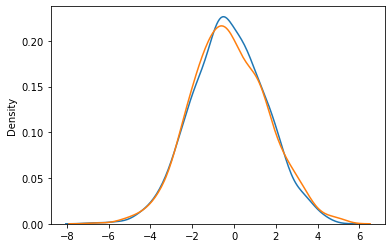

In [5]:
q_models = trace['q_models'][0]
print(q_models.keys())
q1 = q_models['q1_w'][0]
import torch
q1_samples, _ = q1.sample(1000, device='cpu') 
q1_samples = q1_samples.numpy()

sns.kdeplot(q1_samples.squeeze())

q_models = trace['q_models'][0]
print(q_models.keys())
q2 = q_models['q_nfmc_1_w'][0]
import torch
q2_samples, _ = q2.sample(1000, device='cpu') 
q2_samples = q2_samples.numpy()

sns.kdeplot(q2_samples.squeeze())

# Correlated Gaussian test

In [2]:
n = 10

np.random.seed(10)
key = jax.random.PRNGKey(10)
# Draw precision matrix from the Wishart distribution, with n degrees of freedom and identity scale.
wish = scipy.stats.wishart(df=n, scale=np.eye(n))
A = wish.rvs()
detA = jnp.linalg.det(A)

mu = jnp.ones(n)

prior_samples = jax.random.uniform(key, shape=(20, n), minval=-10, maxval=10)

def log_like(x, mu=mu, cov=jnp.linalg.inv(A)):
    return mvn.logpdf(x, mu, cov)

def log_prior(x, loc=-10, scale=20):
    return jnp.sum(jax.scipy.stats.uniform.logpdf(x, loc, scale))

lower = -10 * jnp.ones(n)
upper = 10 * jnp.ones(n)
bounds = jnp.array([lower, upper])
print(bounds)

[[-10. -10. -10. -10. -10. -10. -10. -10. -10. -10.]
 [ 10.  10.  10.  10.  10.  10.  10.  10.  10.  10.]]


In [3]:
trace = nfmc_jax.infer_nfomc(log_like, log_prior, prior_samples, 
                             log_like_args=(mu, jnp.linalg.inv(A)), 
                             log_prior_args=(-10, 20), 
                             bounds=bounds,
                             vmap=True, 
                             parallel_backend=None, 
                             n0=100, 
                             iteration=5, 
                             N_AF=5000, 
                             expl_top_AF=100, 
                             expl_latent=10, 
                             expl_top_qw=10, 
                             local_thresh=3,
                             nfmc_draws=100, 
                             nf_iter=40, 
                             k_trunc=0.5, 
                             ess_tol=0.9, 
                             eps_z=0.05,
                             inference_mode="sampling", 
                             cull_lowp_tol=0.01, 
                             max_cull_frac=0.9,
                             trainable_qw=False, 
                             beta_max=1, 
                             N_temp=1000, 
                             t_ess=0.5,
                             bw_factor_min=1, 
                             bw_factor_max=1, 
                             bw_factor_num=1,
                             nfmc_frac_validate=0.2)

Inference mode is sampling. Maximum beta is set to 1.


/home/richard/nfmc_jax/nfmc_jax/nfomc/nfomc.py:341: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448222085/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  self.nf_model = GIS(torch.from_numpy(np.asarray(self.samples)),
/home/richard/nfmc_jax/nfmc_jax/sinf/SINF.py:494: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at  /opt/cond

logIW3 [-1.8333855e+00 -1.9221764e+00 -5.9754372e-01 -9.3359756e-01
 -2.9644966e-01 -2.3488655e+00  1.8859482e-01 -1.3559532e+00
 -2.2846565e+00 -1.8388481e+00 -1.4500046e+00 -4.2847061e+00
 -2.4651031e+00 -6.0943604e-01 -1.8813324e-01 -2.0895767e-01
 -7.3949051e-01  9.7279358e-01 -1.4747620e-02 -1.0498409e+00
 -2.0702934e-01 -1.6535912e+00 -2.3762894e+00 -2.4356651e-01
 -1.5049667e+00 -1.9164200e+00  5.6190491e-03 -1.6499557e+00
 -3.8504028e-01 -3.6321068e-01 -9.9389267e-01 -1.9600945e+00
 -1.1383972e+00 -6.7138481e-01 -8.3725357e-01 -9.7688675e-01
 -6.7963982e-01 -1.8427620e+00 -2.4186325e-01 -3.1219063e+00
 -4.9378586e-01 -1.3479843e+00 -9.4683456e-01 -1.7809563e+00
  5.0232315e-01 -1.5148754e+00 -7.0320129e-01 -1.2916431e+00
 -5.7706909e+00 -1.0228233e+00 -5.8058033e+00 -9.2315292e-01
 -9.1467667e-01 -2.2602844e-01 -2.9125748e+00 -2.2906075e+00
  6.0008240e-01 -3.3428307e+00 -1.1425972e+00 -2.0293255e+00
 -6.6502571e-01  3.1621933e-01 -1.0690174e+00 -7.5100517e-01
 -1.4894142e+00 -

train_weights = (DeviceArray([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
              12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,
              24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,
              36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,
              48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,
              60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,
              72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
              84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,
              96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107,
             108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
             120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
             132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
             144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
             156, 157, 158, 159, 1

jnp.shape(nfomc.posterior_logp) = (400,)
jnp.shape(jnp.atleast_1d(posterior_logp_new)) = (100,)
logIW3 [ -9.386135  -16.111656   -7.9847946  -1.9251289  -3.9809074  -4.867117
  -7.7347565  -1.5344582 -12.3604355  -8.134895   -5.5141983 -17.927505
  -9.626965   -2.594017  -11.314999   -2.5051918  -4.460455   -7.5516777
  -4.683182  -11.454151   -8.932377  -10.020027   -3.2953262 -12.388208
  -3.1154976  -7.3146515  -5.506098   -3.574009   -4.9213257  -6.1792297
  -5.4720173 -14.59605    -7.1654835  -6.860483   -6.3275757  -4.0370865
  -8.562389   -5.3842964  -8.081608  -11.599426   -3.976286   -6.6910515
  -2.2462273  -9.034552   -5.9262085  -5.1697884  -5.2582893 -10.236534
 -17.483837   -4.9144535 -11.090227   -3.170065   -6.3349037  -2.3598728
  -5.236347  -13.142021  -21.486906  -10.26882    -3.2241402  -6.9667053
  -4.667103   -6.680029   -7.7011375  -3.8139534  -1.762291   -8.229221
  -5.638279   -7.691164  -10.587006   -4.894331   -1.3997002  -6.8728027
  -6.7794094  -8.470604   

jnp.shape(nfomc.posterior_logp) = (500,)
jnp.shape(jnp.atleast_1d(posterior_logp_new)) = (100,)
logIW3 [ -8.898258   -15.328346    -6.286484    -4.041464    -4.206949
  -4.6308193   -6.9694233   -1.9939594  -12.580715    -8.714928
  -6.2787933  -18.943714    -7.7688713   -2.2813225  -12.597389
  -4.819153    -5.011692    -5.2480965   -2.729908   -13.293411
  -7.486355    -8.708714    -6.056076   -11.434628    -5.8983135
  -5.938961    -4.5793724   -4.5854855   -4.266548    -6.3873634
  -5.1798363  -11.851112    -3.2328796   -6.1039486   -8.742035
  -2.9044838   -7.7507324   -3.8555756   -4.276722    -9.6681595
  -3.9530544   -6.199625    -3.2156944   -9.978052    -6.7409916
  -5.183359    -5.6336327  -10.804131   -13.977837    -6.0142365
 -13.115536    -4.4615593   -5.7908325   -2.20574     -4.5741844
 -11.910297   -19.850365    -9.52618     -4.5469704   -7.5457115
  -3.2204514   -6.1032047   -9.03746     -2.8827      -4.237278
  -7.320133    -6.7135773   -6.2746506  -12.522474    -4.4

train_weights = (DeviceArray([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
              12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,
              24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,
              36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,
              48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,
              60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,
              72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
              84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,
              96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107,
             108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
             120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
             132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
             144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
             156, 157, 158, 159, 1

train_weights = (DeviceArray([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
              12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,
              24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,
              36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,
              48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,
              60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,
              72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
              84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,
              96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107,
             108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
             120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
             132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
             144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
             156, 157, 158, 159, 1

train_weights = (DeviceArray([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
              12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,
              24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,
              36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,
              48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,
              60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,
              72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
              84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,
              96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107,
             108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
             120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
             132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
             144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
             156, 157, 158, 159, 1

train_weights = (DeviceArray([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
              12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,
              24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,
              36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,
              48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,
              60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,
              72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
              84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,
              96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107,
             108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
             120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
             132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
             144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
             156, 157, 158, 159, 1

train_weights = (DeviceArray([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
              12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,
              24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,
              36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,
              48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,
              60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,
              72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
              84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,
              96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107,
             108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
             120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
             132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
             144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
             156, 157, 158, 159, 1

train_weights = (DeviceArray([   0,    1,    2, ..., 1297, 1298, 1299], dtype=int32),)
jnp.shape(nfomc.posterior_logp) = (1300,)
jnp.shape(jnp.atleast_1d(posterior_logp_new)) = (100,)
logIW3 [-29.594357 -49.35602  -26.209064 ...  -9.294617 -11.415779  -8.921349]
self.beta before iteration 0.014188710846182001
beta:  1.007094355423091
ESS:  1
beta:  0.5106415331346364
ESS:  1
beta:  0.26241512199040923
ESS:  1
beta:  0.13830191641829562
ESS:  2
beta:  0.07624531363223881
ESS:  4
beta:  0.04521701223921041
ESS:  10
beta:  0.029702861542696204
ESS:  24
beta:  0.021945786194439102
ESS:  51
beta:  0.02582432386856765
ESS:  34
beta:  0.02388505503150338
ESS:  42
beta:  0.022915420612971242
ESS:  46
beta:  0.022430603403705174
ESS:  49
beta:  0.022188194799072136
ESS:  50
self beta 0.022188194799072136
train_weights = (DeviceArray([   0,    1,    2, ..., 1397, 1398, 1399], dtype=int32),)
jnp.shape(nfomc.posterior_logp) = (1400,)
jnp.shape(jnp.atleast_1d(posterior_logp_new)) = (100,)
logIW3 [-

/home/richard/nfmc_jax/nfmc_jax/nfomc/nfomc.py:257: RuntimeWarning: overflow encountered in exp
  inf_weights = jnp.isinf(np.exp(self.log_weight_pq))


jnp.shape(nfomc.posterior_logp) = (1900,)
jnp.shape(jnp.atleast_1d(posterior_logp_new)) = (100,)
logIW3 [-112.61348  -185.74377  -102.90833  ...  -15.675732  -27.637234
  -21.348145]
self.beta before iteration 0.05222603940314628
beta:  1.026113019701573
ESS:  1
beta:  0.5391695295523596
ESS:  2
beta:  0.29569778447775297
ESS:  7
beta:  0.17396191194044963
ESS:  16
beta:  0.11309397567179796
ESS:  28
beta:  0.08266000753747213
ESS:  45
beta:  0.0674430234703092
ESS:  63
beta:  0.07505151550389066
ESS:  53
beta:  0.0788557615206814
ESS:  49
beta:  0.07695363851228604
ESS:  51
beta:  0.07790470001648372
ESS:  50
self beta 0.07790470001648372
train_weights = (DeviceArray([   3,    4,    7, ..., 1997, 1998, 1999], dtype=int32),)


/home/richard/nfmc_jax/nfmc_jax/nfomc/nfomc.py:257: RuntimeWarning: overflow encountered in exp
  inf_weights = jnp.isinf(np.exp(self.log_weight_pq))


jnp.shape(nfomc.posterior_logp) = (2000,)
jnp.shape(jnp.atleast_1d(posterior_logp_new)) = (100,)
logIW3 [-167.5935   -276.22693  -154.66699  ...  -13.522118  -14.728302
  -52.603264]
self.beta before iteration 0.07790470001648372
beta:  1.0389523500082418
ESS:  1
beta:  0.5584285250123627
ESS:  4
beta:  0.31816661251442324
ESS:  8
beta:  0.1980356562654535
ESS:  11
beta:  0.13797017814096862
ESS:  17
beta:  0.10793743907872617
ESS:  23
beta:  0.09292106954760496
ESS:  27
beta:  0.08541288478204434
ESS:  29
beta:  0.08165879239926403
ESS:  29
beta:  0.07978174620787387
ESS:  30
beta:  0.0788432231121788
ESS:  30
beta:  0.07837396156433127
ESS:  30
beta:  0.0781393307904075
ESS:  30
beta:  0.07802201540344561
ESS:  30
beta:  0.07796335770996467
ESS:  30
beta:  0.0779340288632242
ESS:  30
beta:  0.07791936443985396
ESS:  30
beta:  0.07791203222816884
ESS:  30
beta:  0.07790836612232628
ESS:  30
beta:  0.07790653306940501
ESS:  30
beta:  0.07790561654294437
ESS:  30
self beta 0.07790561654

/home/richard/nfmc_jax/nfmc_jax/nfomc/nfomc.py:257: RuntimeWarning: overflow encountered in exp
  inf_weights = jnp.isinf(np.exp(self.log_weight_pq))


jnp.shape(nfomc.posterior_logp) = (2100,)
jnp.shape(jnp.atleast_1d(posterior_logp_new)) = (100,)
logIW3 [-167.58163  -274.01324  -155.01648  ...  -23.82373   -16.068415
  -27.274319]
self.beta before iteration 0.07790561654294437
beta:  1.038952808271472
ESS:  1
beta:  0.5584292124072082
ESS:  5
beta:  0.3181674144750763
ESS:  11
beta:  0.19803651550901033
ESS:  18
beta:  0.13797106602597736
ESS:  29
beta:  0.10793834128446086
ESS:  41
beta:  0.09292197891370262
ESS:  49
beta:  0.0854137977283235
ESS:  52
beta:  0.08916788832101305
ESS:  50
self beta 0.08916788832101305
train_weights = (DeviceArray([   3,    4,    7, ..., 2197, 2198, 2199], dtype=int32),)


/home/richard/nfmc_jax/nfmc_jax/nfomc/nfomc.py:257: RuntimeWarning: overflow encountered in exp
  inf_weights = jnp.isinf(np.exp(self.log_weight_pq))


jnp.shape(nfomc.posterior_logp) = (2200,)
jnp.shape(jnp.atleast_1d(posterior_logp_new)) = (100,)
logIW3 [-193.76659  -315.58673  -178.1964   ...  -40.426987  -13.552948
  -14.22459 ]
self.beta before iteration 0.08916788832101305
beta:  1.0445839441605065
ESS:  1
beta:  0.5668759162407597
ESS:  5
beta:  0.3280219022808864
ESS:  9
beta:  0.2085948953009497
ESS:  11
beta:  0.14888139181098137
ESS:  15
beta:  0.11902464006599721
ESS:  20
beta:  0.10409626419350512
ESS:  25
beta:  0.09663207625725909
ESS:  28
beta:  0.09289998228913607
ESS:  30
beta:  0.09103393530507456
ESS:  32
beta:  0.0901009118130438
ESS:  32
beta:  0.08963440006702843
ESS:  33
beta:  0.08940114419402073
ESS:  33
beta:  0.08928451625751689
ESS:  33
beta:  0.08922620228926498
ESS:  33
beta:  0.08919704530513901
ESS:  33
beta:  0.08918246681307604
ESS:  33
beta:  0.08917517756704454
ESS:  33
beta:  0.0891715329440288
ESS:  33
beta:  0.08916971063252092
ESS:  33
beta:  0.08916879947676698
ESS:  33
self beta 0.08916879947

/home/richard/nfmc_jax/nfmc_jax/nfomc/nfomc.py:257: RuntimeWarning: overflow encountered in exp
  inf_weights = jnp.isinf(np.exp(self.log_weight_pq))


jnp.shape(nfomc.posterior_logp) = (2300,)
jnp.shape(jnp.atleast_1d(posterior_logp_new)) = (100,)
logIW3 [-193.1163   -314.74335  -177.09796  ...  -16.500126  -15.04937
  -17.833103]
self.beta before iteration 0.08916879947676698
beta:  1.0445843997383835
ESS:  1
beta:  0.5668765996075752
ESS:  5
beta:  0.3280226995421711
ESS:  16
beta:  0.20859574950946905
ESS:  35
beta:  0.14888227449311803
ESS:  54
beta:  0.17873901200129355
ESS:  43
beta:  0.1638106432472058
ESS:  48
beta:  0.1563464588701619
ESS:  51
beta:  0.16007855105868385
ESS:  49
beta:  0.15821250496442288
ESS:  50
self beta 0.15821250496442288
train_weights = (DeviceArray([   3,    7,   24, ..., 2397, 2398, 2399], dtype=int32),)


/home/richard/nfmc_jax/nfmc_jax/nfomc/nfomc.py:257: RuntimeWarning: overflow encountered in exp
  inf_weights = jnp.isinf(np.exp(self.log_weight_pq))


jnp.shape(nfomc.posterior_logp) = (2400,)
jnp.shape(jnp.atleast_1d(posterior_logp_new)) = (100,)
logIW3 [-341.6796   -561.0051   -317.83475  ...  -26.954025  -19.925732
  -17.990881]
self.beta before iteration 0.15821250496442288
beta:  1.0791062524822115
ESS:  2
beta:  0.6186593787233172
ESS:  3
beta:  0.38843594184387004
ESS:  6
beta:  0.27332422340414647
ESS:  13
beta:  0.2157683641842847
ESS:  23
beta:  0.18699043457435377
ESS:  33
beta:  0.17260146976938834
ESS:  40
beta:  0.16540698736690562
ESS:  44
beta:  0.16180974616566424
ESS:  46
beta:  0.16001112556504354
ESS:  47
beta:  0.15911181526473323
ESS:  48
beta:  0.15866216011457807
ESS:  48
beta:  0.15843733253950049
ESS:  48
beta:  0.1583249187519617
ESS:  49
beta:  0.1582687118581923
ESS:  49
beta:  0.1582406084113076
ESS:  49
beta:  0.15822655668786523
ESS:  49
beta:  0.15821953082614404
ESS:  49
beta:  0.15821601789528345
ESS:  49
beta:  0.15821426142985318
ESS:  49
beta:  0.158213383197138
ESS:  49
self beta 0.1582133831971

/home/richard/nfmc_jax/nfmc_jax/nfomc/nfomc.py:257: RuntimeWarning: overflow encountered in exp
  inf_weights = jnp.isinf(np.exp(self.log_weight_pq))


jnp.shape(nfomc.posterior_logp) = (2500,)
jnp.shape(jnp.atleast_1d(posterior_logp_new)) = (100,)
logIW3 [-342.06543  -561.3209   -317.31873  ...  -18.4402    -17.779234
  -19.329613]
self.beta before iteration 0.158213383197138
beta:  1.079106691598569
ESS:  2
beta:  0.6186600373978535
ESS:  4
beta:  0.3884367102974957
ESS:  12
beta:  0.27332504674731684
ESS:  28
beta:  0.21576921497222742
ESS:  50
self beta 0.21576921497222742
train_weights = (DeviceArray([   7,   40,   61, ..., 2597, 2598, 2599], dtype=int32),)


/home/richard/nfmc_jax/nfmc_jax/nfomc/nfomc.py:257: RuntimeWarning: overflow encountered in exp
  inf_weights = jnp.isinf(np.exp(self.log_weight_pq))


jnp.shape(nfomc.posterior_logp) = (2600,)
jnp.shape(jnp.atleast_1d(posterior_logp_new)) = (100,)
logIW3 [-465.05536  -766.44946  -433.1821   ...  -20.491184  -20.801193
  -19.594162]
self.beta before iteration 0.21576921497222742
beta:  1.1078846074861137
ESS:  15
beta:  0.6618269112291706
ESS:  32
beta:  0.438798063100699
ESS:  49
beta:  0.32728363903646324
ESS:  67
beta:  0.3830408510685811
ESS:  56
beta:  0.41091945708464006
ESS:  52
beta:  0.42485876009266954
ESS:  51
beta:  0.4318284115966843
ESS:  50
self beta 0.4318284115966843
train_weights = (DeviceArray([ 294,  451,  496, ..., 2697, 2698, 2699], dtype=int32),)


/home/richard/nfmc_jax/nfmc_jax/nfomc/nfomc.py:257: RuntimeWarning: overflow encountered in exp
  inf_weights = jnp.isinf(np.exp(self.log_weight_pq))


jnp.shape(nfomc.posterior_logp) = (2700,)
jnp.shape(jnp.atleast_1d(posterior_logp_new)) = (100,)
logIW3 [ -932.54803  -1535.5073    -870.1509   ...   -28.275448   -26.338184
   -27.76951 ]
self.beta before iteration 0.4318284115966843
beta:  1.215914205798342
ESS:  51
beta:  1.607957102899171
ESS:  28
beta:  1.4119356543487567
ESS:  38
beta:  1.3139249300735494
ESS:  44
beta:  1.2649195679359457
ESS:  47
beta:  1.240416886867144
ESS:  49
beta:  1.228165546332743
ESS:  50
self beta 1
train_weights = (DeviceArray([1312, 1344, 1348, 1349, 1369, 1386, 1427, 1435, 1441, 1485,
             1488, 1491, 1494, 1495, 1500, 1501, 1502, 1503, 1504, 1505,
             1507, 1508, 1509, 1510, 1511, 1512, 1514, 1516, 1519, 1521,
             1522, 1523, 1526, 1527, 1528, 1529, 1531, 1532, 1534, 1535,
             1536, 1537, 1538, 1539, 1540, 1541, 1542, 1543, 1544, 1546,
             1550, 1552, 1553, 1555, 1556, 1557, 1558, 1560, 1561, 1562,
             1563, 1566, 1567, 1568, 1569, 1570, 1571, 15

/home/richard/nfmc_jax/nfmc_jax/nfomc/nfomc.py:257: RuntimeWarning: overflow encountered in exp
  inf_weights = jnp.isinf(np.exp(self.log_weight_pq))


jnp.shape(nfomc.posterior_logp) = (2800,)
jnp.shape(jnp.atleast_1d(posterior_logp_new)) = (100,)
Culling low-p NFO samples ...
Removing 2610 samples with the lowest logp values.
Stage 1; Fitting un-weighted nf
Stage 1; Fitting weighted nf
train_weights = (DeviceArray([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
              12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,
              24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,
              36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,
              48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,
              60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,
              72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
              84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,
              96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107,
             108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
             1

Stage 4; Fitting weighted nf
train_weights = (DeviceArray([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
              12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,
              24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,
              36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,
              48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,
              60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,
              72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
              84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,
              96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107,
             108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
             120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
             132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
             144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
     

Stage 6; Fitting weighted nf
train_weights = (DeviceArray([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
              12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,
              24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,
              36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,
              48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,
              60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,
              72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
              84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,
              96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107,
             108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
             120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
             132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
             144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
     

Stage 7; Update nfmc step
update_nfmc: Drawing samples from qw
update_nfmc: Evaluating logp values
update_nfmc: Calculating evidences.
update_nfmc: Local exploration
update_nfmc: Concatenating new samples
Stage 8; Fitting un-weighted nf
Stage 8; Fitting weighted nf
train_weights = (DeviceArray([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
              12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,
              24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,
              36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,
              48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,
              60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,
              72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
              84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,
              96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107,
             108, 109, 110, 111, 112, 113, 114, 115, 116, 11

/home/richard/nfmc_jax/nfmc_jax/nfomc/nfomc.py:257: RuntimeWarning: overflow encountered in exp
  inf_weights = jnp.isinf(np.exp(self.log_weight_pq))


Stage 13; Update nfmc step
update_nfmc: Drawing samples from qw
update_nfmc: Evaluating logp values
update_nfmc: Calculating evidences.
update_nfmc: Local exploration
update_nfmc: Concatenating new samples
Stage 14; Fitting un-weighted nf
Stage 14; Fitting weighted nf
train_weights = (DeviceArray([   0,    1,    2, ..., 1587, 1588, 1589], dtype=int32),)
Stage 14; Update nfmc step
update_nfmc: Drawing samples from qw
update_nfmc: Evaluating logp values
update_nfmc: Calculating evidences.
update_nfmc: Local exploration
update_nfmc: Concatenating new samples
Stage 15; Fitting un-weighted nf
Stage 15; Fitting weighted nf
train_weights = (DeviceArray([1250], dtype=int32),)


ValueError: cannot convert float NaN to integer

[4.95072747e-08 6.32175943e-04 1.85495774e-05 ... 2.60004003e-06
 1.70363401e-05 2.07522726e-06]
1.0


<Figure size 432x288 with 0 Axes>

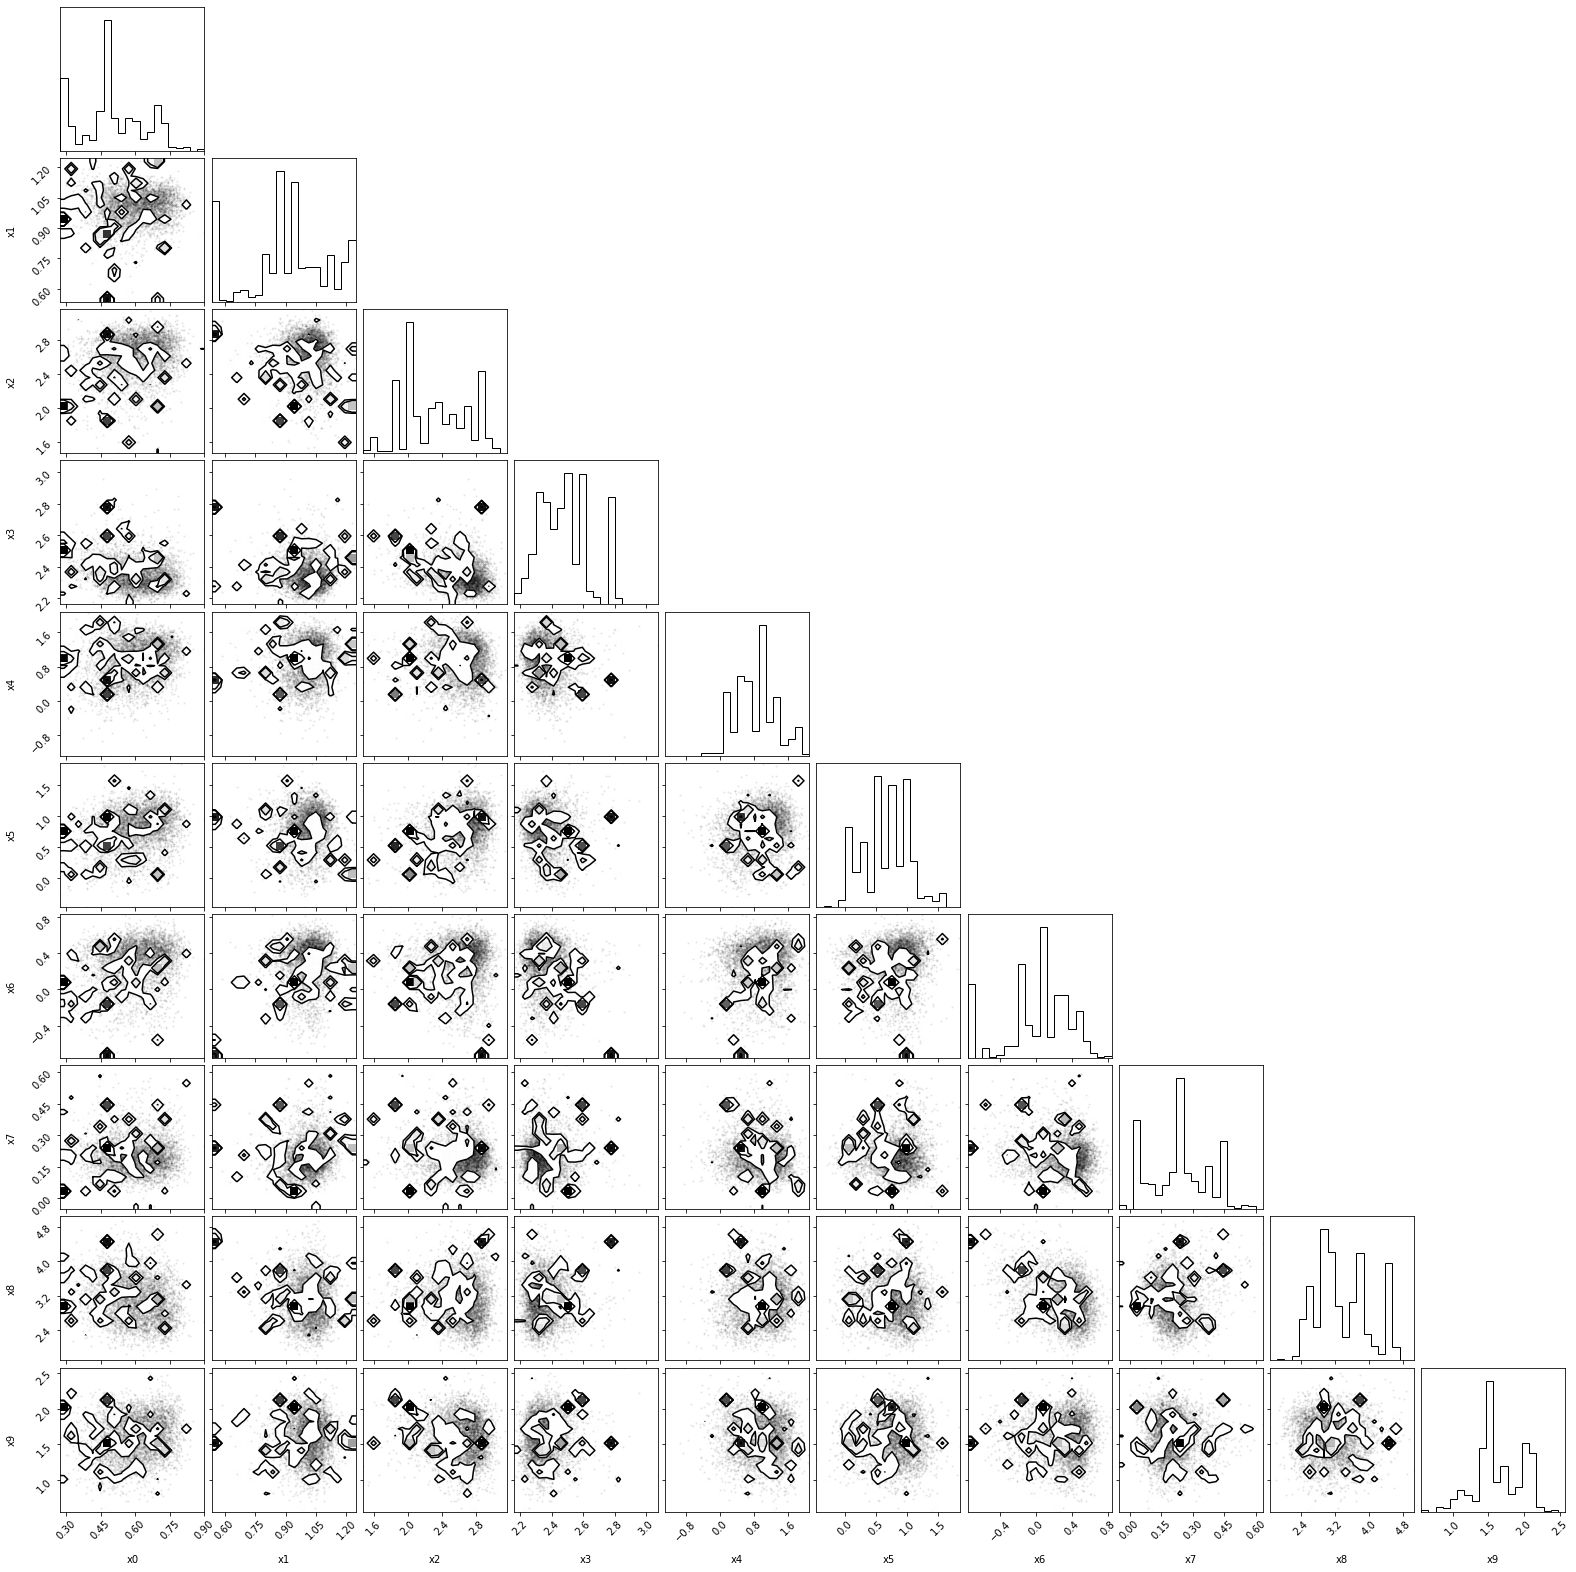

In [5]:
posterior = np.asarray(trace['qw_posterior'][0])
betas = trace['betas']

keys = [f'x{i}' for i in range(n)]
samples = {}
for i, key in enumerate(keys):
    samples[key] = posterior[:, i]

x = np.asarray(posterior).squeeze()
w = np.asarray(trace['qw_posterior_weights'][0]).astype(np.float64)
print(w)
w /= w.sum()
print(np.sum(w))

plt.figure()
corner.corner(samples, weights=w)
plt.show()

[1.61792834e-12 9.38740569e-16 6.58642528e-15 ... 1.68310031e-02
 7.06584603e-02 1.70819549e-04]
1.0


<Figure size 432x288 with 0 Axes>

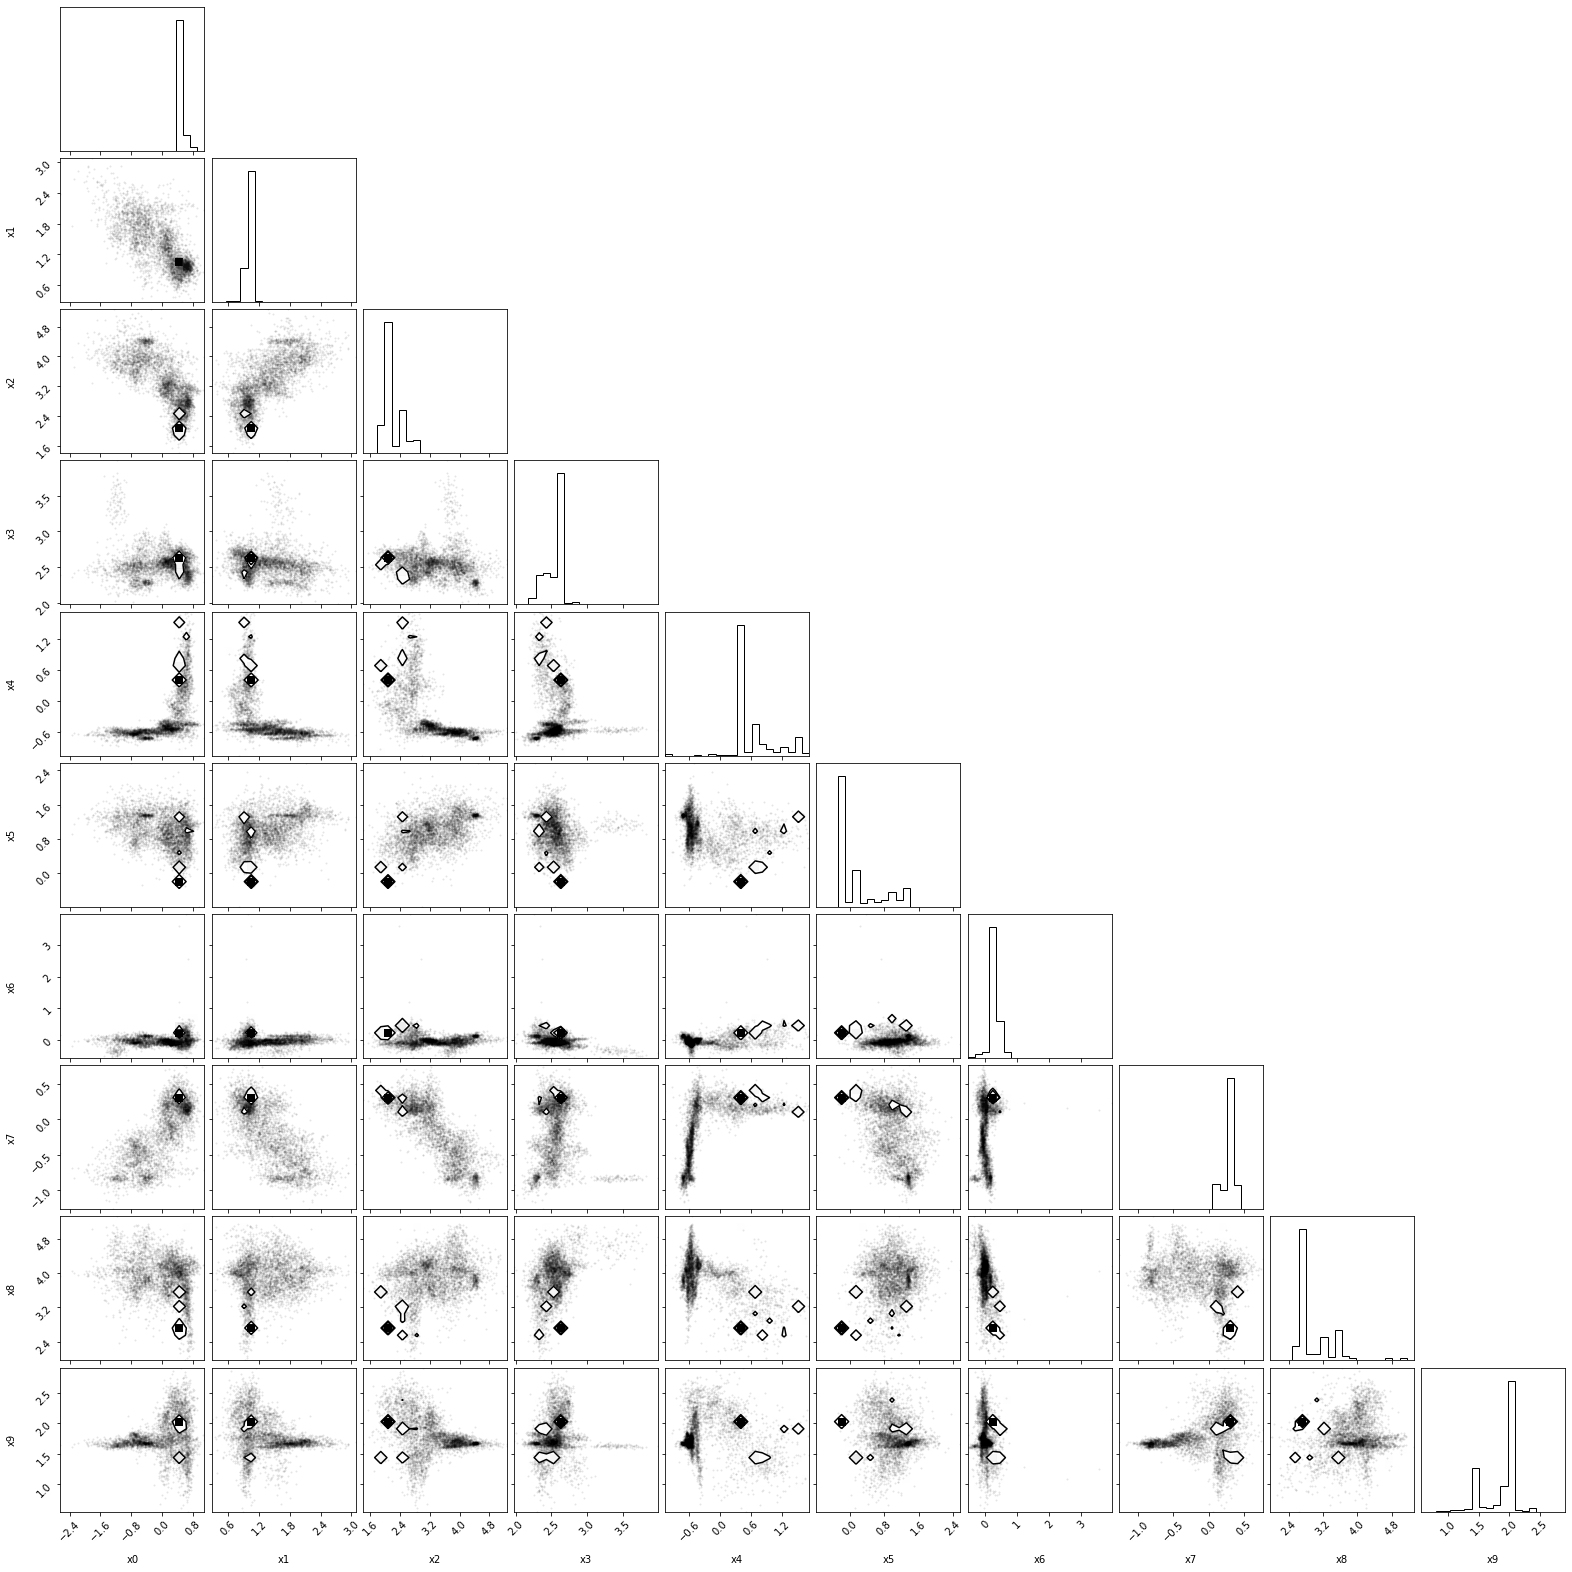

In [6]:
posterior = np.asarray(trace['quw_posterior'][0])
betas = trace['betas']

keys = [f'x{i}' for i in range(n)]
samples = {}
for i, key in enumerate(keys):
    samples[key] = posterior[:, i]

x = np.asarray(posterior).squeeze()
w = np.asarray(trace['quw_posterior_weights'][0]).astype(np.float64)
print(w)
w /= w.sum()
print(np.sum(w))

plt.figure()
corner.corner(samples, weights=w)
plt.show()

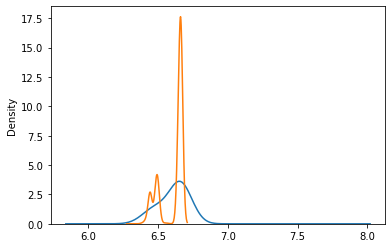

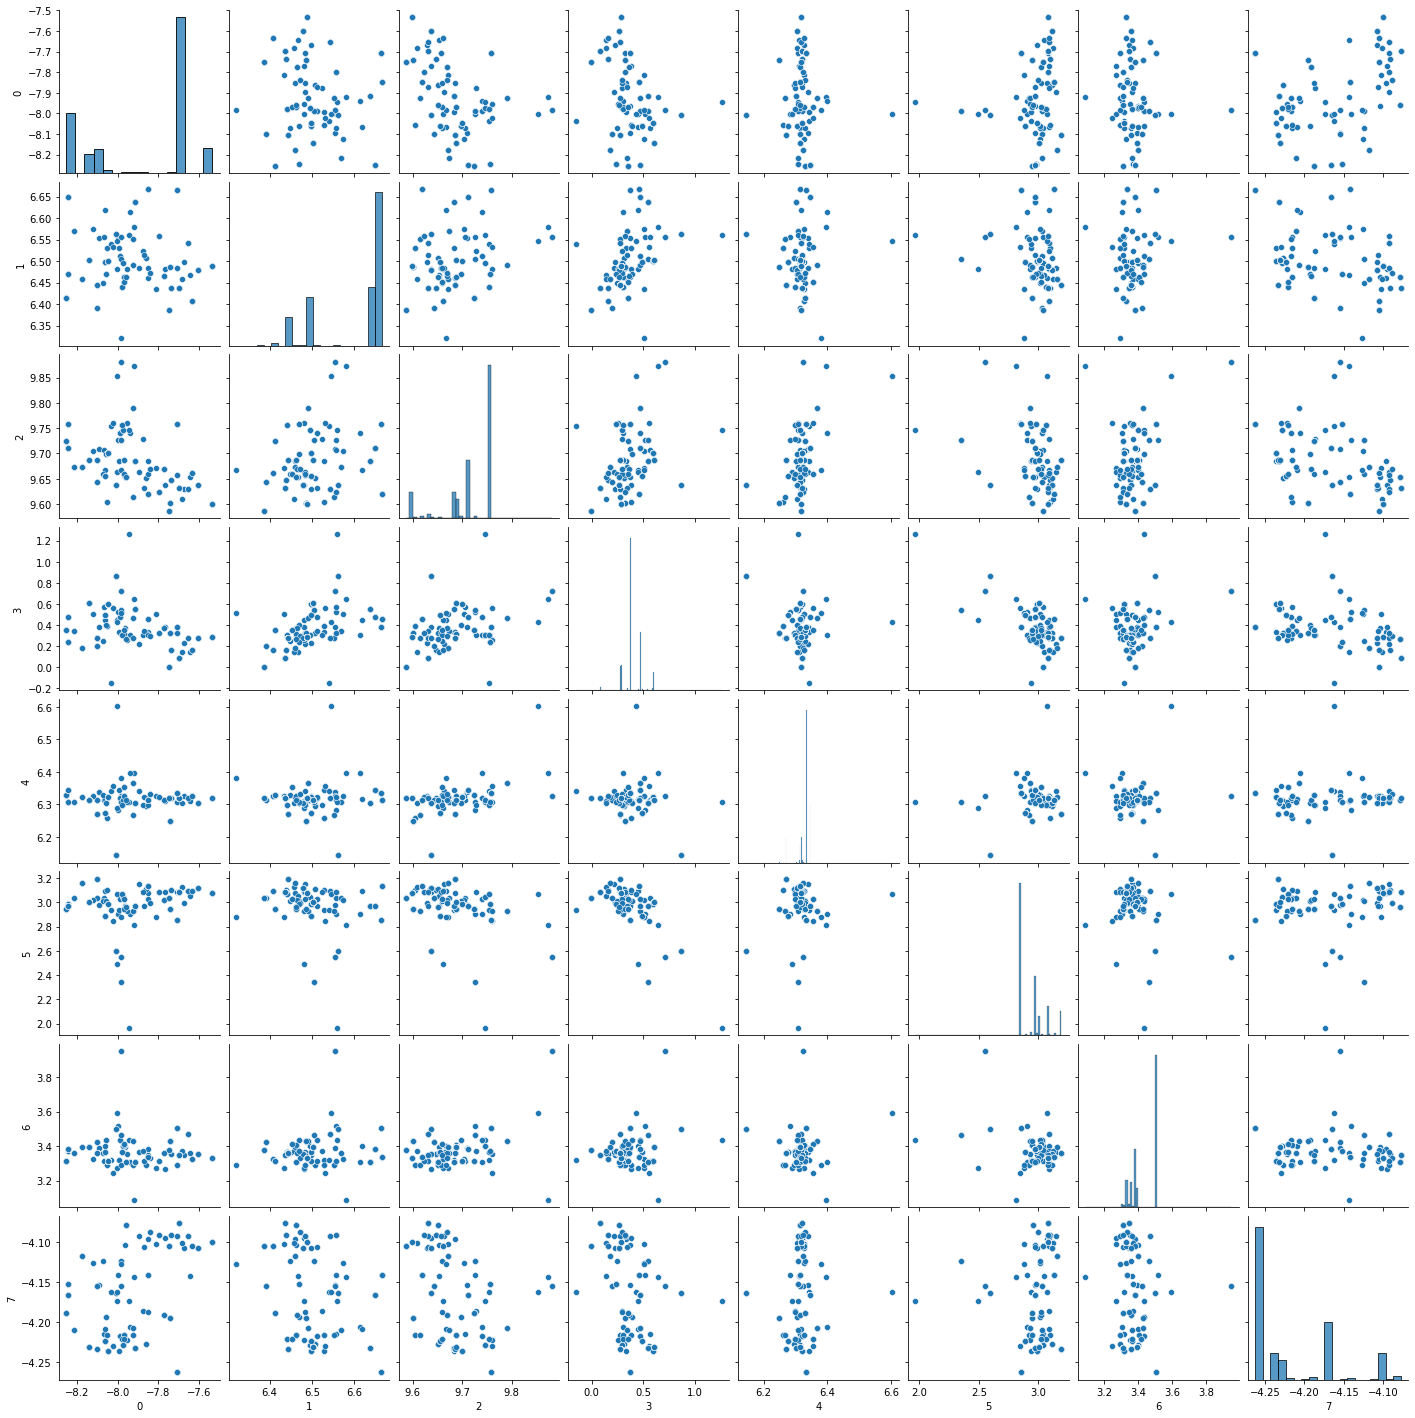

In [7]:
sns.kdeplot(posterior[:,1], weights=w)

resamp_idx = np.random.choice(np.arange(len(posterior)), size=len(posterior), p=w)
posterior = posterior[resamp_idx, ...]

sns.kdeplot(posterior[:,1])
sns.pairplot(pd.DataFrame(posterior[:, 0:8]))

dict_keys(['q1_w', 'q1_uw', 'q2_w', 'q2_uw', 'q3_w', 'q3_uw', 'q4_w', 'q4_uw', 'q5_w', 'q5_uw', 'q6_w', 'q6_uw', 'q7_w', 'q7_uw', 'q8_w', 'q8_uw', 'q9_w', 'q9_uw', 'q10_w', 'q10_uw', 'q11_w', 'q11_uw', 'q12_w', 'q12_uw', 'q13_w', 'q13_uw', 'q14_w', 'q14_uw', 'q15_w', 'q15_uw', 'q16_w', 'q16_uw', 'q17_w', 'q17_uw', 'q18_w', 'q18_uw', 'q19_w', 'q19_uw', 'q20_w', 'q20_uw', 'q21_w', 'q21_uw', 'q22_w', 'q22_uw', 'q23_w', 'q23_uw', 'q24_w', 'q24_uw', 'q25_w', 'q25_uw', 'q26_w', 'q26_uw', 'q27_w', 'q27_uw', 'q28_w', 'q28_uw', 'q_nfmc_1_w', 'q_nfmc_1_uw', 'q_nfmc_2_w', 'q_nfmc_2_uw', 'q_nfmc_3_w', 'q_nfmc_3_uw', 'q_nfmc_4_w', 'q_nfmc_4_uw', 'q_nfmc_5_w', 'q_nfmc_5_uw', 'q_nfmc_6_w', 'q_nfmc_6_uw', 'q_nfmc_7_w', 'q_nfmc_7_uw', 'q_nfmc_8_w', 'q_nfmc_8_uw', 'q_nfmc_9_w', 'q_nfmc_9_uw', 'q_nfmc_10_w', 'q_nfmc_10_uw', 'q_nfmc_11_w', 'q_nfmc_11_uw', 'q_nfmc_12_w', 'q_nfmc_12_uw', 'q_nfmc_13_w', 'q_nfmc_13_uw', 'q_nfmc_14_w', 'q_nfmc_14_uw', 'q_nfmc_15_w', 'q_nfmc_15_uw', 'q_nfmc_16_w', 'q_nfmc_16_uw

<Figure size 432x288 with 0 Axes>

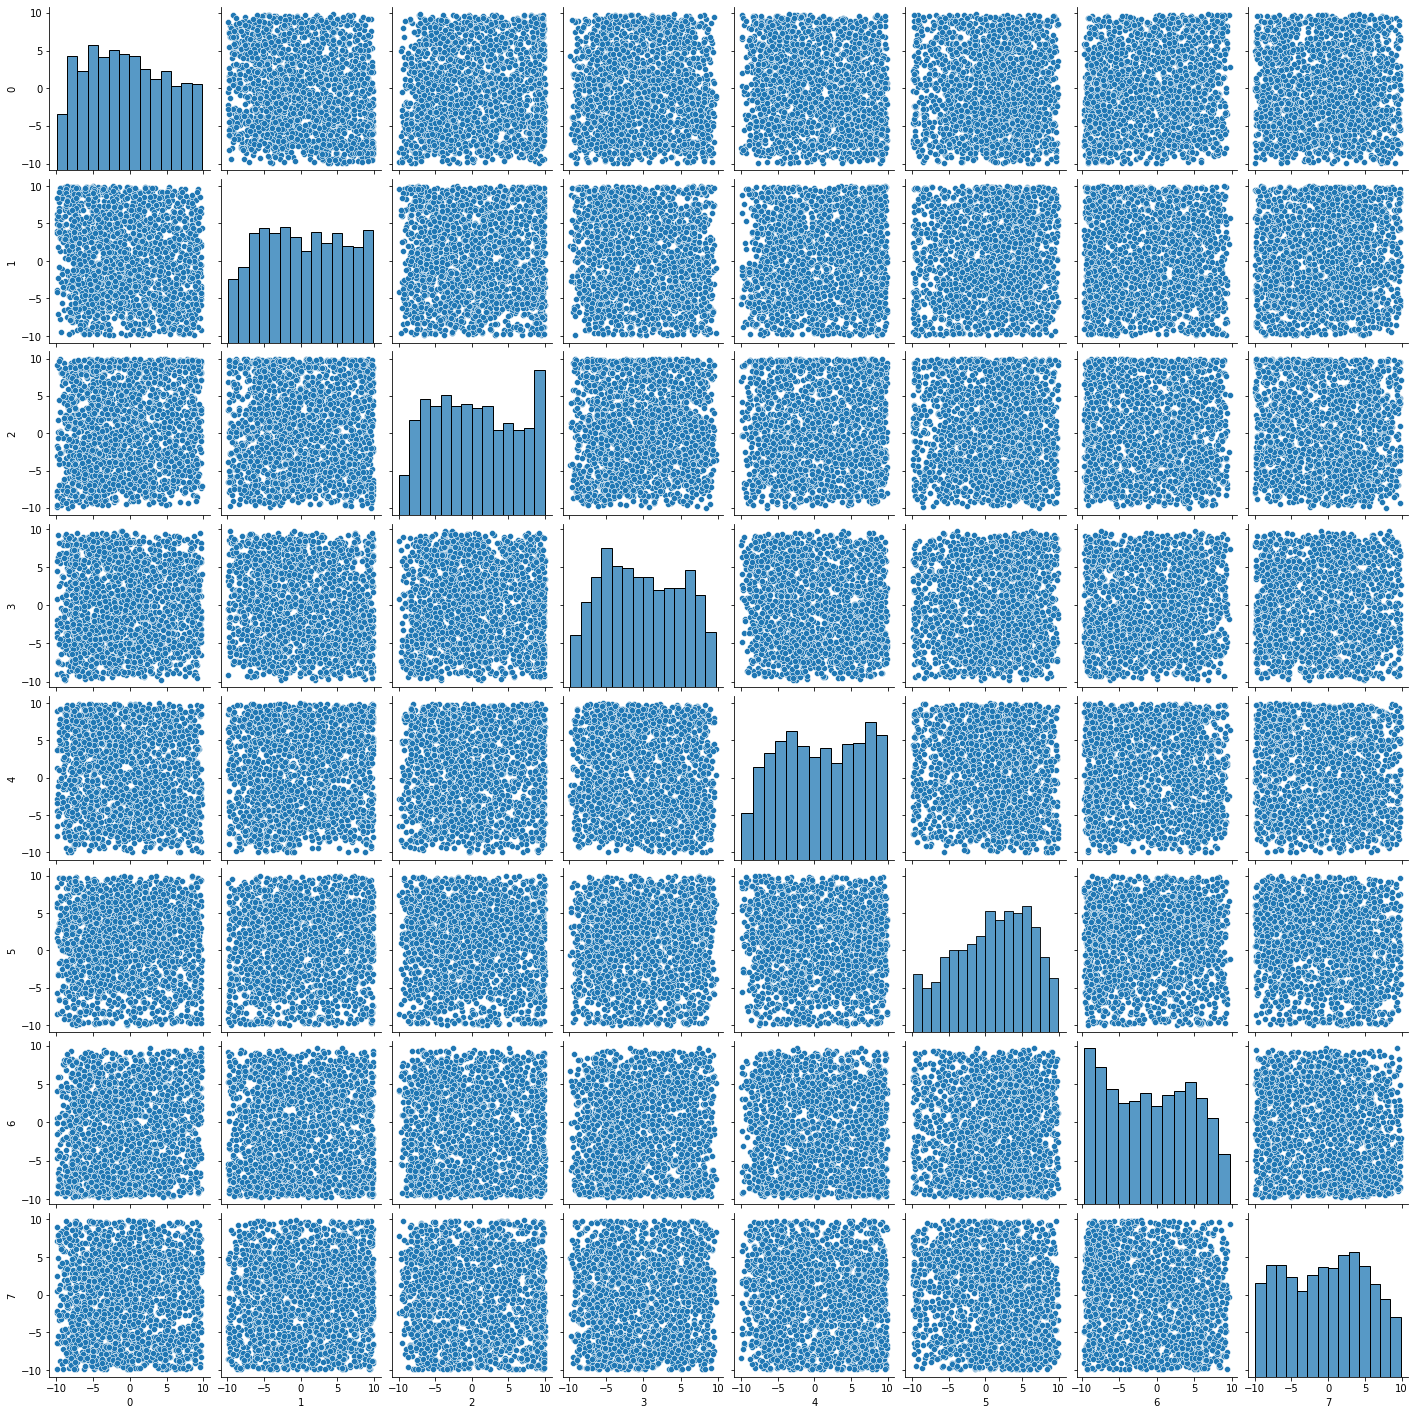

In [14]:
q_models = trace['q_models'][0]
print(q_models.keys())

qw = q_models['q28_w'][0]
qw_samples = qw.sample(2000, device='cpu')[0].numpy()

keys = [f'x{i}' for i in range(n)]
samples = {}
for i, key in enumerate(keys):
    samples[key] = qw_samples[:, i]
    
plt.figure()
sns.pairplot(pd.DataFrame(qw_samples[:, 0:8]))
plt.show()


<Figure size 432x288 with 0 Axes>

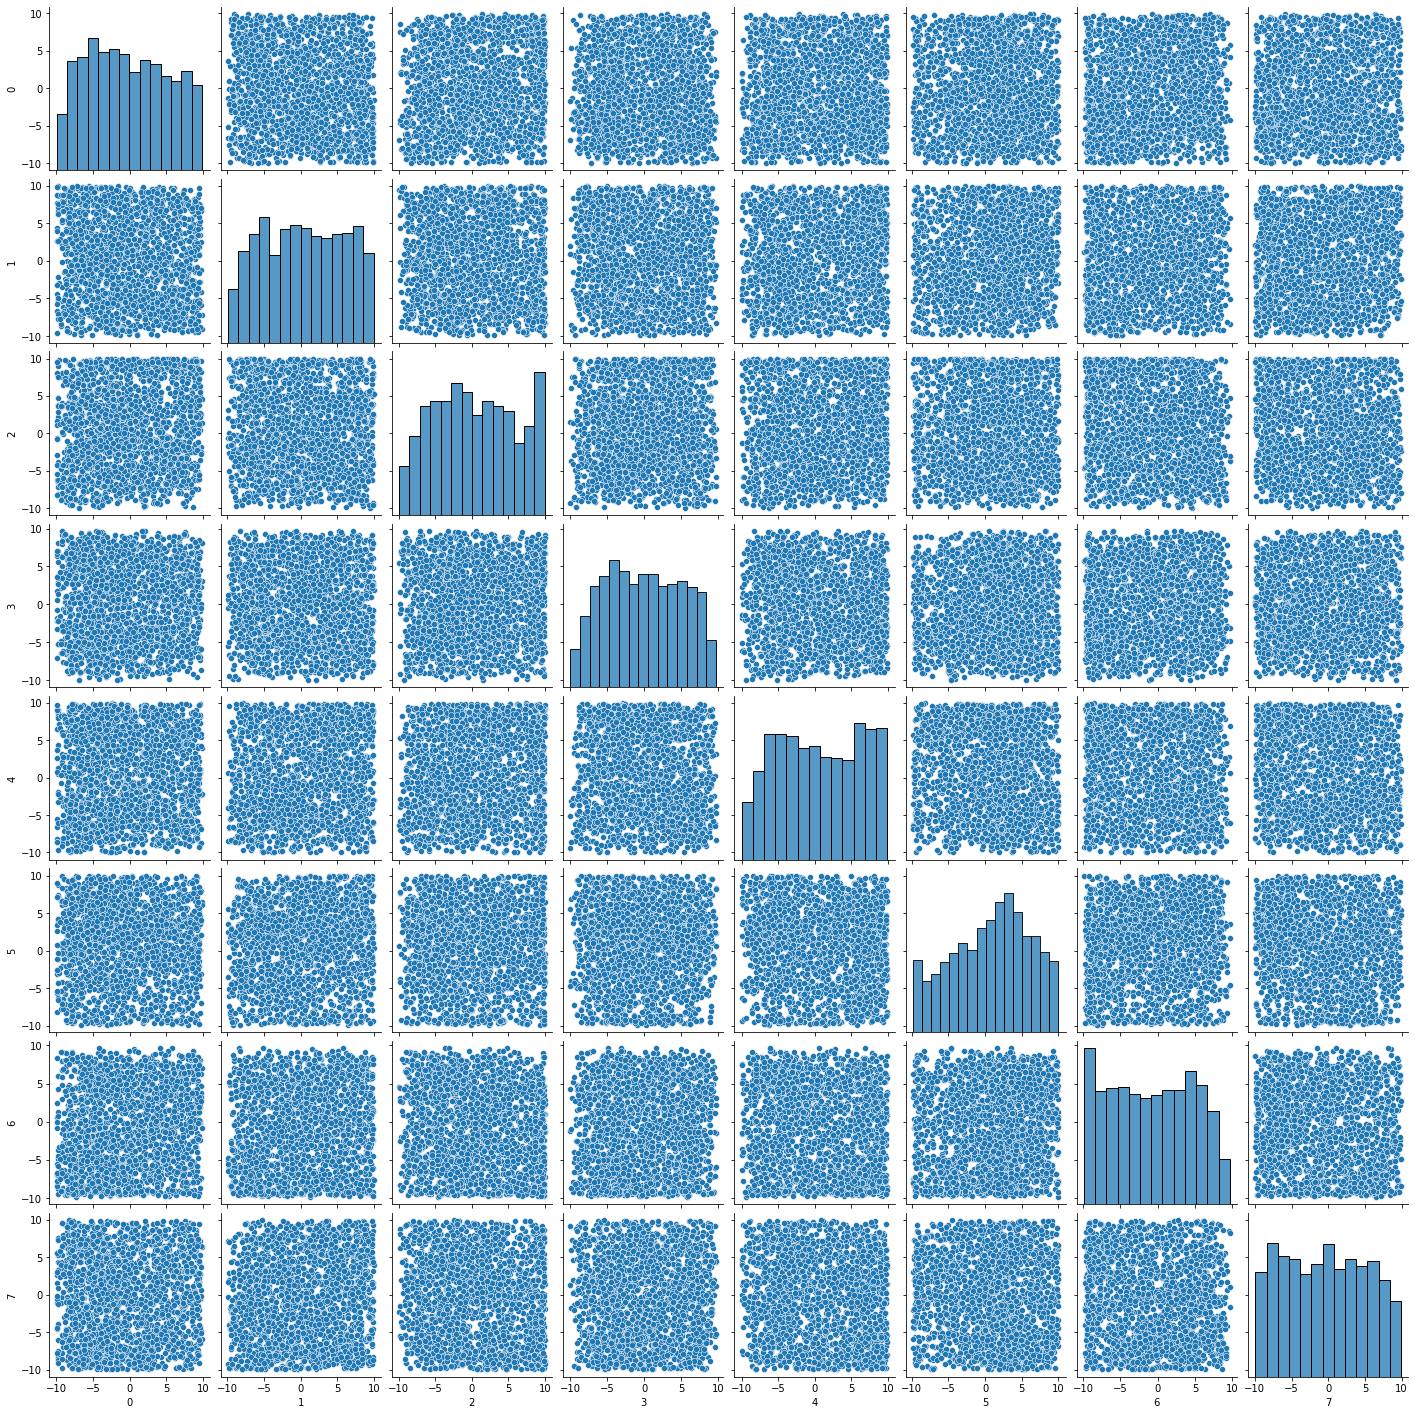

In [13]:
q_models = trace['q_models'][0]
q_models.keys()

quw = q_models['q_nfmc_40_w'][0]
quw_samples = qw.sample(2000, device='cpu')[0].numpy()

keys = [f'x{i}' for i in range(n)]
samples = {}
for i, key in enumerate(keys):
    samples[key] = quw_samples[:, i]
   
plt.figure()
sns.pairplot(pd.DataFrame(quw_samples[:, 0:8]))
plt.show()

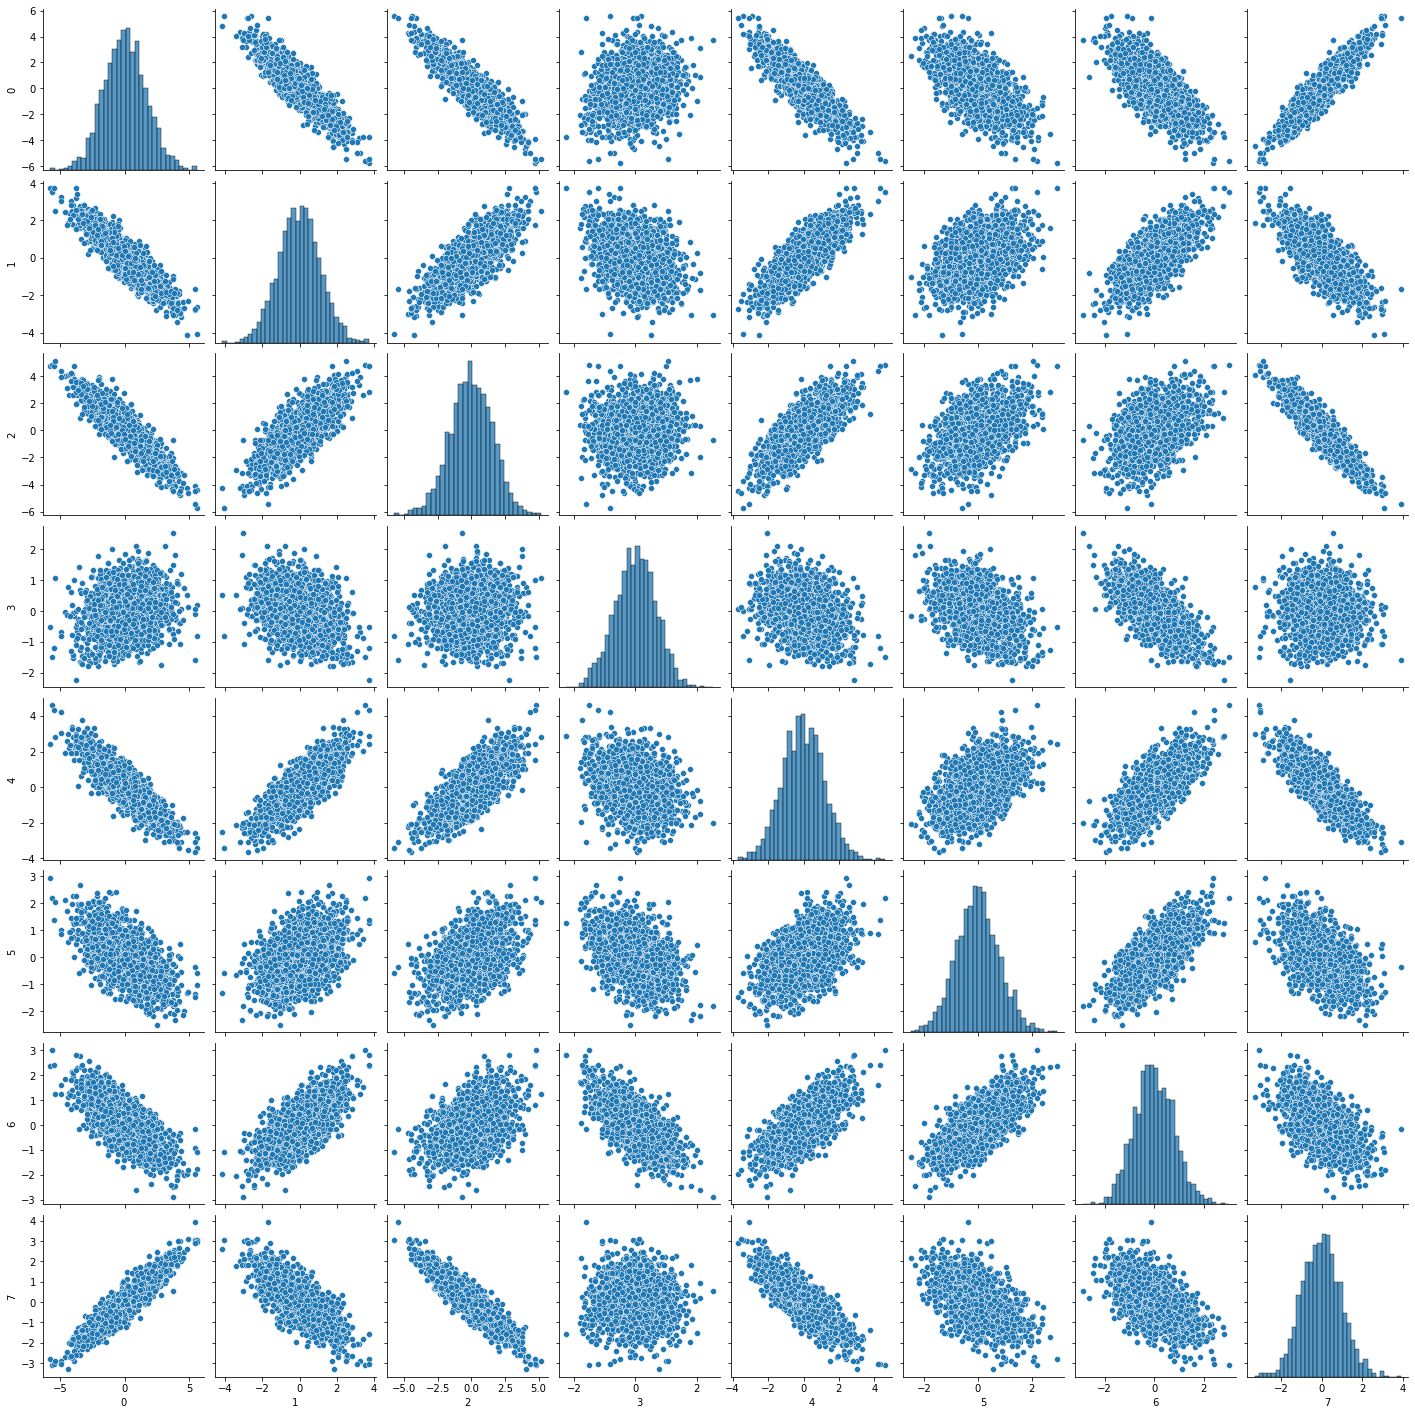

In [15]:
g_truth = np.random.multivariate_normal(np.zeros(10), cov=np.linalg.inv(A), size=2000)
df_truth = pd.DataFrame(g_truth[:, 0:8])
sns.pairplot(df_truth)

# JS pmap test ...

In [2]:
n=1
n_iter=1 #sinf iterations 
n_prior = 10 #number of sobol points
n_samples = n_prior #not used explicitly
n0=n_prior
N=n_samples
#get sobol sequence for initial samples
low,high=-1.0,1.0
dist1d = chaospy.Iid(chaospy.Uniform(lower=low,upper=high),n)
init_prior=dist1d
init_prior = np.atleast_2d(dist1d.sample(n_prior,rule='sobol')).T
knots=None
# knots=5
knots_trainable=5 
bw=1.
rel_bw=1
layers=5
ktrunc=np.inf #no clip
t_ess=0.7
g_AF=0
aN=int(2*N)
bN=1
beta_max=1.5
rel_beta=1
frac_rel_beta_AF = 1
bounds=np.array([low*np.ones(n),high*np.ones(n)])
alpha_w = (0,0)
alpha_uw = (0,0)
use_latent_beta2=False
use_pq_beta_IW1=False
cN=0
dN=0
trainable_qw=False
sgd_steps=0
latent_sigma=1
seed=-1

In [3]:
def log_like(x, mu=jnp.zeros(n), sigma=1/10*jnp.ones(n)):
    return -0.5 * jnp.log(2 * jnp.pi * jnp.prod(sigma** 2) ) - 0.5 * jnp.dot((x - mu)**2 , (1/ (2 * sigma ** 2)))

def log_prior(x):
    return -n*jnp.log(2)

trace = nfmc_jax.infer_nfomc(inference_mode='optimization',
                             log_like_func=log_like, 
                             log_prior_func=log_prior, 
                             init_samples=init_prior, 
                             log_like_args=(), log_prior_args=(),
                             vmap=False, parallel_backend=None, 
                               n0=n0,
                               N=N,
                               t_ess=t_ess,
                               g_AF=g_AF,
                               N_AF=aN,
                               expl_top_AF=bN,
                               expl_latent=cN,
                               expl_top_qw=dN,
                               bounds=bounds,
                               beta_max=beta_max,
                               nf_iter=n_iter, 
                               N_temp=25,
                               rel_bw=rel_bw,
                               rel_beta=rel_beta,
                               frac_rel_beta_AF = frac_rel_beta_AF,
                               latent_sigma=latent_sigma,
                               use_latent_beta2=use_latent_beta2,
                               use_pq_beta_IW1=use_pq_beta_IW1,
                               #chains=1, 
                               k_trunc=ktrunc,
                               #sinf parameters
                               frac_validate=0.0,
                               alpha_w=alpha_w,
                               alpha_uw=alpha_uw,
                               NBfirstlayer=True, 
                               verbose=True,interp_nbin=knots,iteration=layers,
                               bw_factor_min=bw,bw_factor_max=bw,bw_factor_num=1, #manually force bw factor
                               trainable_qw=trainable_qw,
                               sgd_steps=sgd_steps,
                               knots_trainable=knots_trainable,
                               random_seed=seed
#                              n0=20, iteration=5, aN=100, bN=10, num_local=2,
#                             nfmc_samples=10, nf_iter=10, k_trunc=0.5, ess_tol=1.0
                            )

Inference mode is optimization. Maximum beta is: 1.5
stage:  0
stage:  1
No weights in the fit. bw_uw = 1.00 bw_w
After boundary transform logp: -0.8109225034713745
Fit spline Time: 0.002235889434814453
logp: -0.6097343564033508 time: 0.0049364566802978516 iteration: 2
Fit spline Time: 0.001268625259399414
logp: -0.576472282409668 time: 0.0025093555450439453 iteration: 3
Fit spline Time: 0.0013854503631591797
logp: -0.5575479865074158 time: 0.002671480178833008 iteration: 4
Fit spline Time: 0.0011544227600097656
logp: -0.5410507917404175 time: 0.002310514450073242 iteration: 5
logIW3 [ 0.08547521 -0.11270094 -0.14468181  0.06078959 -0.28717494  0.00533712
 -0.3234868  -0.31068587 -0.05191422 -0.4419217 ]
self.beta before iteration 0
beta:  1.0
ESS:  1
beta:  0.5
ESS:  2
beta:  0.25
ESS:  3
beta:  0.125
ESS:  5
beta:  0.0625
ESS:  7
self beta 0.0625
weighting fit
After boundary transform logp: -0.48146432638168335
Fit spline Time: 0.0014586448669433594
logp: -0.46615251898765564 time: 0

/home/richard/nfmc_jax/nfmc_jax/nfomc/nfomc.py:333: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448222085/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  self.nf_model = GIS(torch.from_numpy(np.asarray(self.samples)),
/home/richard/nfmc_jax/nfmc_jax/sinf/SINF.py:494: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at  /opt/cond

stage:  2
No weights in the fit. bw_uw = 1.00 bw_w
After boundary transform logp: -0.7598125338554382
Fit spline Time: 0.0013918876647949219
logp: -0.6053368449211121 time: 0.002882719039916992 iteration: 2
Fit spline Time: 0.0012912750244140625
logp: -0.578854501247406 time: 0.002475261688232422 iteration: 3
Fit spline Time: 0.0011665821075439453
logp: -0.5615769624710083 time: 0.0022809505462646484 iteration: 4
Fit spline Time: 0.0015411376953125
logp: -0.5456669926643372 time: 0.002740144729614258 iteration: 5
logIW3 [ 0.02360427 -0.4836256  -0.34883648  0.027592   -0.9302362  -0.19452769
 -1.007666   -0.70709634 -0.33518696 -1.4187965  -0.09210557]
self.beta before iteration 0.0625
beta:  1.03125
ESS:  2
beta:  0.546875
ESS:  3
beta:  0.3046875
ESS:  4
beta:  0.18359375
ESS:  5
beta:  0.123046875
ESS:  6
beta:  0.0927734375
ESS:  7
self beta 0.0927734375
weighting fit
After boundary transform logp: -0.4107453227043152
Fit spline Time: 0.0013697147369384766
logp: -0.3559518754482269

/home/richard/nfmc_jax/nfmc_jax/nfomc/infer_nfomc.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dlogq_w = dlogq_w[prior_mask]


stage:  3
No weights in the fit. bw_uw = 1.00 bw_w
After boundary transform logp: -0.7165685296058655
Fit spline Time: 0.0026264190673828125
logp: -0.5917791128158569 time: 0.004782438278198242 iteration: 2
Fit spline Time: 0.002173900604248047
logp: -0.5666213631629944 time: 0.004055500030517578 iteration: 3
Fit spline Time: 0.0018432140350341797
logp: -0.548168957233429 time: 0.004227161407470703 iteration: 4
Fit spline Time: 0.0017075538635253906
logp: -0.5310925245285034 time: 0.0035016536712646484 iteration: 5
logIW3 [-0.07756454 -0.63843757 -0.38906205  0.01240814 -1.1484532  -0.36694443
 -1.2969154  -0.8365737  -0.5071234  -1.851208   -0.24572521 -0.21204859]
self.beta before iteration 0.0927734375
beta:  1.04638671875
ESS:  3
beta:  0.569580078125
ESS:  4
beta:  0.3311767578125
ESS:  5
beta:  0.21197509765625
ESS:  6
beta:  0.152374267578125
ESS:  7
self beta 0.152374267578125
weighting fit
After boundary transform logp: -0.33340370655059814
Fit spline Time: 0.00146389007568359

/home/richard/nfmc_jax/nfmc_jax/nfomc/infer_nfomc.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dlogq_w = dlogq_w[prior_mask]


stage:  4
No weights in the fit. bw_uw = 1.00 bw_w
After boundary transform logp: -0.679530918598175
Fit spline Time: 0.0014271736145019531
logp: -0.5717387795448303 time: 0.0029103755950927734 iteration: 2
Fit spline Time: 0.0012564659118652344
logp: -0.5439831614494324 time: 0.002497434616088867 iteration: 3
Fit spline Time: 0.0011315345764160156
logp: -0.5224056243896484 time: 0.0023491382598876953 iteration: 4
Fit spline Time: 0.0015106201171875
logp: -0.5029982328414917 time: 0.002915620803833008 iteration: 5
logIW3 [-1.3442022e-01 -8.8131857e-01 -5.6620014e-01  9.0283155e-04
 -1.7413687e+00 -5.1712590e-01 -1.9715039e+00 -1.2162199e+00
 -6.9280481e-01 -2.8360083e+00 -3.6307138e-01 -3.1865484e-01
 -2.7732092e-01]
self.beta before iteration 0.152374267578125
beta:  1.0761871337890625
ESS:  3
beta:  0.6142807006835938
ESS:  5
beta:  0.3833274841308594
ESS:  6
beta:  0.2678508758544922
ESS:  6
beta:  0.2101125717163086
ESS:  7
self beta 0.2101125717163086
weighting fit
After boundary 

/home/richard/nfmc_jax/nfmc_jax/nfomc/infer_nfomc.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dlogq_w = dlogq_w[prior_mask]


stage:  5
No weights in the fit. bw_uw = 1.00 bw_w
After boundary transform logp: -0.6477864384651184
Fit spline Time: 0.002504587173461914
logp: -0.5458657741546631 time: 0.004091739654541016 iteration: 2
Fit spline Time: 0.001575469970703125
logp: -0.512365460395813 time: 0.003839731216430664 iteration: 3
Fit spline Time: 0.0015778541564941406
logp: -0.4857400357723236 time: 0.0030188560485839844 iteration: 4
Fit spline Time: 0.0015156269073486328
logp: -0.46315816044807434 time: 0.004449605941772461 iteration: 5
logIW3 [-0.18539524 -1.0816996  -0.7253916   0.01382512 -2.3217409  -0.64718676
 -2.6350074  -1.5834107  -0.8391894  -3.7999144  -0.47301185 -0.42001897
 -0.37638235 -0.37290102]
self.beta before iteration 0.2101125717163086
beta:  1.1050562858581543
ESS:  4
beta:  0.6575844287872314
ESS:  6
beta:  0.43384850025177
ESS:  6
beta:  0.3219805359840393
ESS:  7
self beta 0.3219805359840393
weighting fit
After boundary transform logp: -0.26623037457466125
Fit spline Time: 0.001396

/home/richard/nfmc_jax/nfmc_jax/nfomc/infer_nfomc.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dlogq_w = dlogq_w[prior_mask]


stage:  6
No weights in the fit. bw_uw = 1.00 bw_w
After boundary transform logp: -0.6203231811523438
Fit spline Time: 0.0014891624450683594
logp: -0.518013060092926 time: 0.00809025764465332 iteration: 2
Fit spline Time: 0.0013091564178466797
logp: -0.47674494981765747 time: 0.008233308792114258 iteration: 3
Fit spline Time: 0.0014424324035644531
logp: -0.44425731897354126 time: 0.015009641647338867 iteration: 4
Fit spline Time: 0.0014183521270751953
logp: -0.41659730672836304 time: 0.006992340087890625 iteration: 5
logIW3 [-0.15093881 -1.5209873  -1.1373689   0.04364866 -3.6008568  -0.76690197
 -3.9964342  -2.4089947  -1.0687194  -5.739427   -0.5306752  -0.46037334
 -0.38750768 -0.39196816 -0.40307295]
self.beta before iteration 0.3219805359840393
beta:  1.1609902679920197
ESS:  5
beta:  0.7414854019880295
ESS:  6
beta:  0.5317329689860344
ESS:  7
self beta 0.5317329689860344
weighting fit
After boundary transform logp: -0.2487787902355194
Fit spline Time: 0.0033762454986572266
logp:

/home/richard/nfmc_jax/nfmc_jax/nfomc/infer_nfomc.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dlogq_w = dlogq_w[prior_mask]


stage:  7
No weights in the fit. bw_uw = 1.00 bw_w
After boundary transform logp: -0.5963649153709412
Fit spline Time: 0.0015637874603271484
logp: -0.48678064346313477 time: 0.002824544906616211 iteration: 2
Fit spline Time: 0.0013930797576904297
logp: -0.43481871485710144 time: 0.009136676788330078 iteration: 3
Fit spline Time: 0.0016818046569824219
logp: -0.3945712745189667 time: 0.006769418716430664 iteration: 4
Fit spline Time: 0.0014832019805908203
logp: -0.36102962493896484 time: 0.0070781707763671875 iteration: 5
logIW3 [ 0.03143966 -2.4209523  -2.0216446   0.07957822 -6.1256933  -0.88505244
 -6.6092377  -4.060711   -1.4782937  -9.430352   -0.5012562  -0.3964131
 -0.29983342 -0.30049247 -0.313451   -0.33389676]
self.beta before iteration 0.5317329689860344
beta:  1.2658664844930172
ESS:  6
beta:  0.8987997267395258
ESS:  7
self beta 0.8987997267395258
weighting fit
After boundary transform logp: -0.24059079587459564
Fit spline Time: 0.0016756057739257812
logp: 1.089564561843872 

/home/richard/nfmc_jax/nfmc_jax/nfomc/infer_nfomc.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dlogq_w = dlogq_w[prior_mask]


stage:  8
No weights in the fit. bw_uw = 1.00 bw_w
After boundary transform logp: -0.5753589272499084
Fit spline Time: 0.0016472339630126953
logp: -0.4535475969314575 time: 0.0032694339752197266 iteration: 2
Fit spline Time: 0.0014147758483886719
logp: -0.3895367980003357 time: 0.003968477249145508 iteration: 3
Fit spline Time: 0.0014579296112060547
logp: -0.33998903632164 time: 0.002927541732788086 iteration: 4
Fit spline Time: 0.0015981197357177734
logp: -0.29853883385658264 time: 0.007358074188232422 iteration: 5
logIW3 [  0.44965392  -4.0799093   -3.6714745    0.11744785 -10.669413
  -1.0144944  -11.226354    -7.0416946   -2.2020216  -15.929039
  -0.33712924  -0.16870397  -0.02494526  -0.01647198  -0.03970009
  -0.07091117  -0.12954384]
self.beta before iteration 0.8987997267395258
beta:  1.449399863369763
ESS:  7
self beta 1
weighting fit
After boundary transform logp: -0.2400522232055664
Fit spline Time: 0.0015773773193359375
logp: 1.1535788774490356 time: 0.003464937210083008 it

/home/richard/nfmc_jax/nfmc_jax/nfomc/infer_nfomc.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dlogq_w = dlogq_w[prior_mask]


Finished NFO ...


# 2D double Gaussian example

In [ ]:
key = jax.random.PRNGKey(100)
prior_samples = jax.random.multivariate_normal(key, mean=jnp.array([0.0, 0.0]), 
                                               cov=100 * jnp.eye(2), shape=(20,))
prior_samples.shape[1]

n=2
#shift the peaks to be in between the samples - diagonals
mu1 = jnp.ones(n) * 0.625 # #2(.25)
mu2 = jnp.ones(n) * -0.325 # #2(-.375)

scale_stdev = 1 #4
stdev = 0.1 / scale_stdev
sigma = jnp.power(stdev, 2) * jnp.eye(n)
isigma = jnp.linalg.inv(sigma)
dsigma = jnp.linalg.det(sigma)

w1 = 0.3  # one mode with 0.3 of the mass 
w2 = 1 - w1  # the other mode with 0.7 of the mass

def log_like(x):
    log_like1 = jax.scipy.stats.multivariate_normal.logpdf(x, mu1, sigma)
    log_like2 = jax.scipy.stats.multivariate_normal.logpdf(x, mu2, sigma)
    return logsumexp(jnp.array([jnp.log(w1) + log_like1, jnp.log(w2) + log_like2]), axis=0)

def log_prior(x, mu=jnp.zeros(2), cov=100 * jnp.eye(2)):
    return jax.scipy.stats.multivariate_normal.logpdf(x, mu, cov)

In [ ]:
trace = nfmc_jax.sample_nfo(log_like, log_prior, prior_samples, log_like_args=(), 
                            log_prior_args=(jnp.zeros(2), 100 * jnp.eye(2)),
                            vmap=True, parallel_backend=None, n0=20, iteration=5, aN=100, bN=10, num_local=2,
                            nfmc_samples=20, nf_iter=10, k_trunc=0.5, ess_tol=1.0)

In [ ]:
sns.kdeplot(x=trace['posterior'][0][:,0], y=trace['posterior'][0][:,1],
            weights=trace['posterior_weights'][0])

# Prior samples sanity check ...

In [ ]:
n=1
n_iter=1 #sinf iterations 
n_prior = 10#number of sobol points
n_samples = n_prior #not used explicitly
n0=n_prior
N=n_samples
#get sobol sequence for initial samples
low,high=-1.0,1.0
dist1d = chaospy.Iid(chaospy.Uniform(lower=low,upper=high),n)
init_prior=dist1d
init_prior = np.atleast_2d(dist1d.sample(n_prior,rule='sobol')).T
# init_prior=None
transform=None#'ahh'#'ahh' #turn off pymc3 transform 
if(transform is not None):
    trname='t'
    #logit( (x-a) / (b-a) )
    init_prior = None#inv_logit(init_prior,low,high)#logit((init_prior-low) /(high-low))
else:
    trname='nt'
knots=None#100 #default None
bw=0.5#None#1.#None#0.5#1. #default 2.0
redraw=False #don't redraw samples at every iteration, my local change
layers=2
ktrunc=np.inf #currently SKIPPING
bw_use_pq=True #whether to use pq loss in determining bw
t_ess=0.5
g_AF=1
aN=int(2*N)#10
bN=1#2#int(N/2)
beta_max=1.0

In [ ]:
print(np.shape(init_prior))